In [1]:
%matplotlib inline


=== Running qSAT prototype for: AND ===


-- UF results --
Result counts: {'00': 262, '10': 264, '01': 267, '11': 231}
Circuit depth: 5
Total gates: 8
Operations count: OrderedDict([('h', 3), ('measure', 2), ('oracle_tt', 1), ('diffuser', 1), ('comp_tt', 1)])


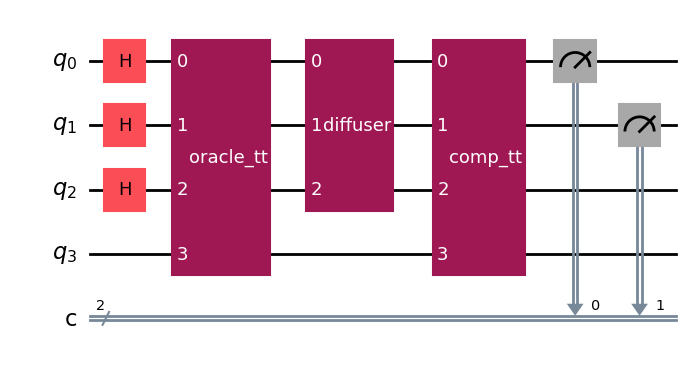

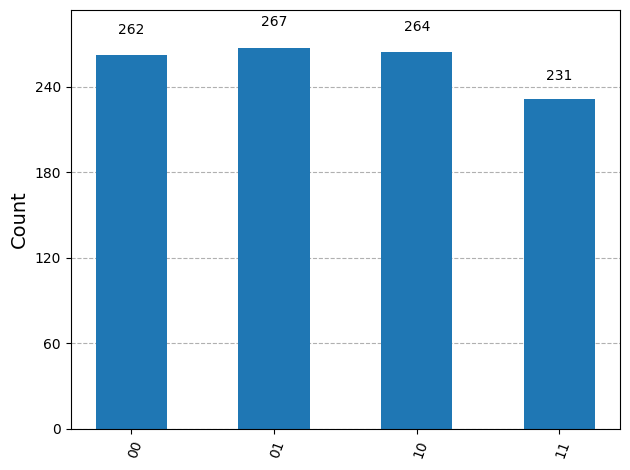


-- VF results --
Result counts: {'11': 239, '01': 259, '10': 266, '00': 260}
Circuit depth: 3
Total gates: 6
Operations count: OrderedDict([('h', 3), ('measure', 2), ('comp_tt', 1)])


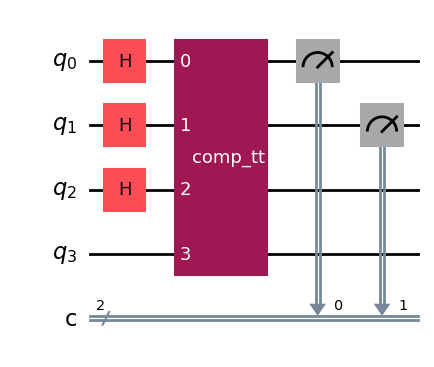

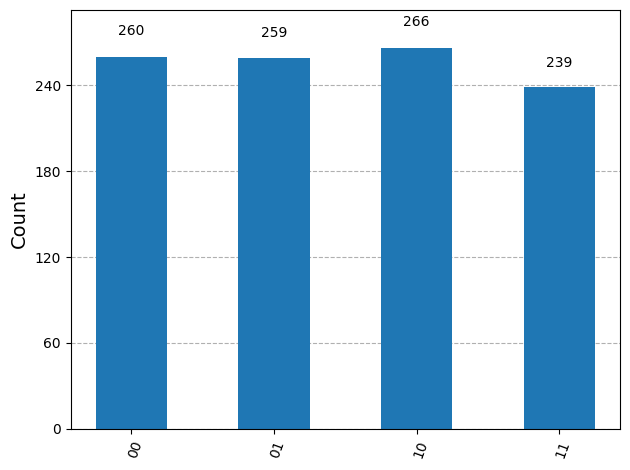


=== UF vs VF Comparison: AND ===
| Ref   |   #CEXs |   GI |   P(SAT)% |   Qubits |   Depth |   Gates |
|-------|---------|------|-----------|----------|---------|---------|
| UF    |       4 |    1 |       100 |        4 |       5 |       8 |
| VF    |       0 |    0 |         0 |        4 |       3 |       6 |

=== Running qSAT prototype for: MUX_ESOP ===


-- UF results --
Result counts: {'110': 133, '100': 110, '000': 135, '010': 117, '111': 144, '101': 131, '001': 110, '011': 144}
Circuit depth: 7
Total gates: 13
Operations count: OrderedDict([('h', 5), ('measure', 3), ('oracle_tt', 2), ('diffuser', 2), ('comp_tt', 1)])


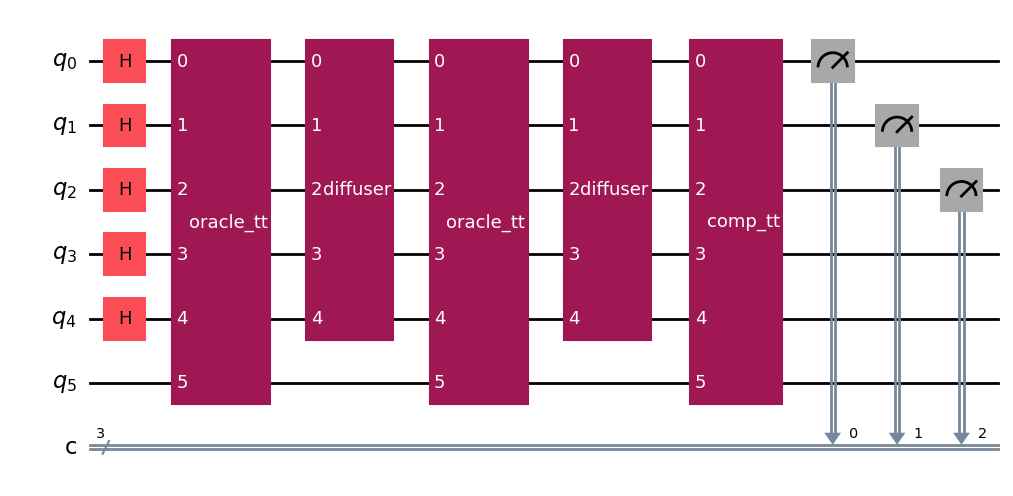

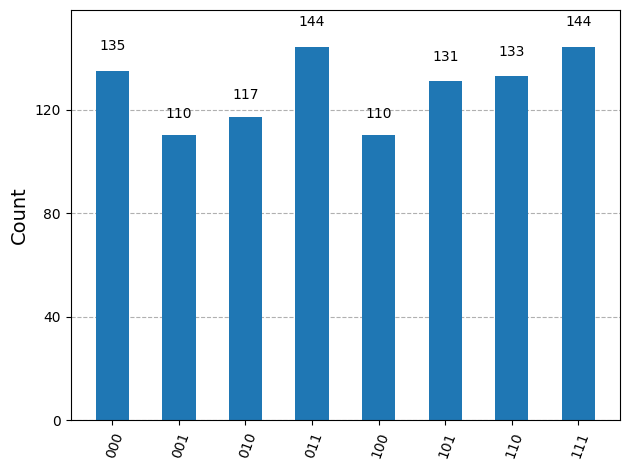


-- VF results --
Result counts: {'010': 131, '100': 107, '110': 131, '011': 125, '001': 121, '111': 137, '101': 134, '000': 138}
Circuit depth: 5
Total gates: 10
Operations count: OrderedDict([('h', 4), ('measure', 3), ('oracle_tt', 1), ('diffuser', 1), ('comp_tt', 1)])


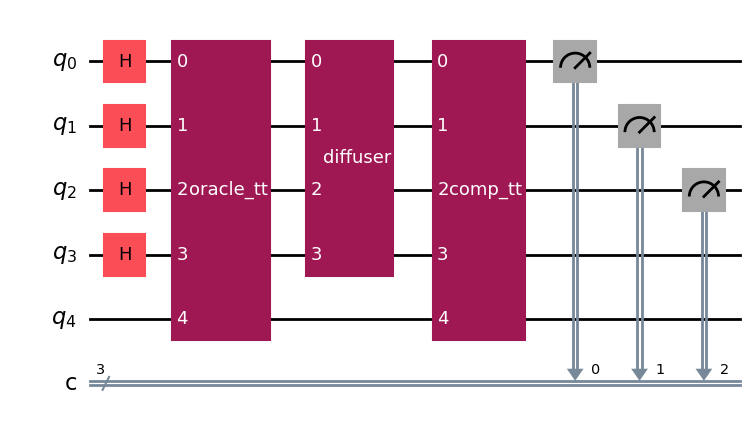

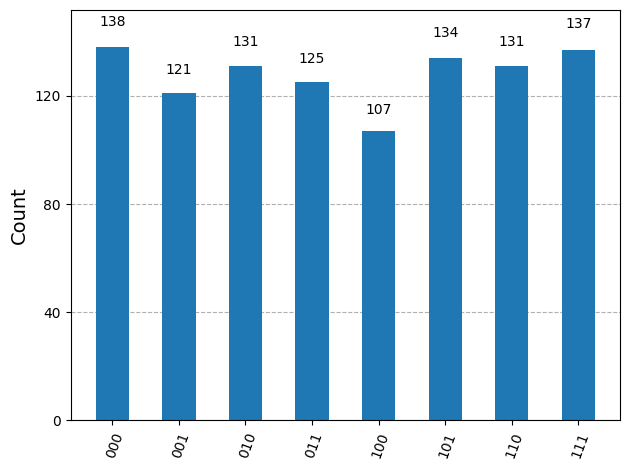


=== UF vs VF Comparison: MUX_ESOP ===
| Ref   |   #CEXs |   GI |   P(SAT)% |   Qubits |   Depth |   Gates |
|-------|---------|------|-----------|----------|---------|---------|
| UF    |       8 |    2 |       100 |        6 |       7 |      13 |
| VF    |       8 |    1 |       100 |        5 |       5 |      10 |

=== Running qSAT prototype for: FA_ESOP ===


-- UF results --
Result counts: {'101': 114, '001': 143, '000': 125, '111': 141, '010': 123, '011': 127, '100': 138, '110': 113}
Circuit depth: 3
Total gates: 10
Operations count: OrderedDict([('h', 6), ('measure', 3), ('comp_tt', 1)])


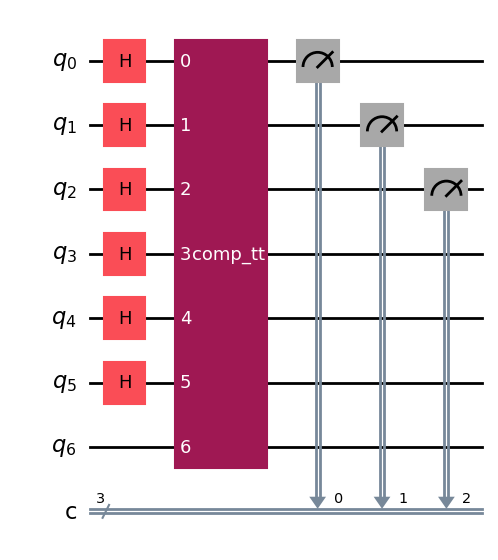

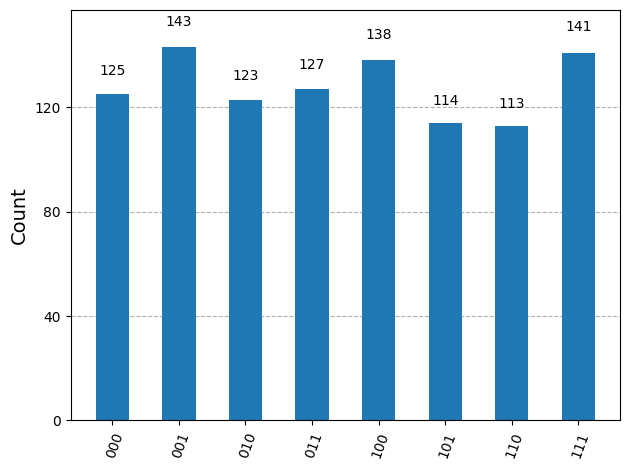


-- VF results --
Result counts: {'100': 101, '110': 136, '011': 119, '101': 129, '001': 122, '000': 133, '111': 137, '010': 147}
Circuit depth: 3
Total gates: 9
Operations count: OrderedDict([('h', 5), ('measure', 3), ('comp_tt', 1)])


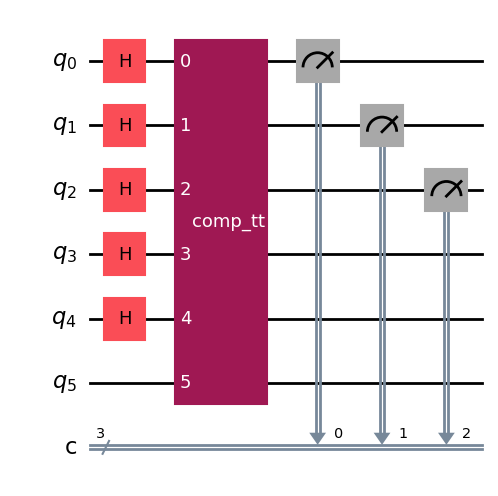

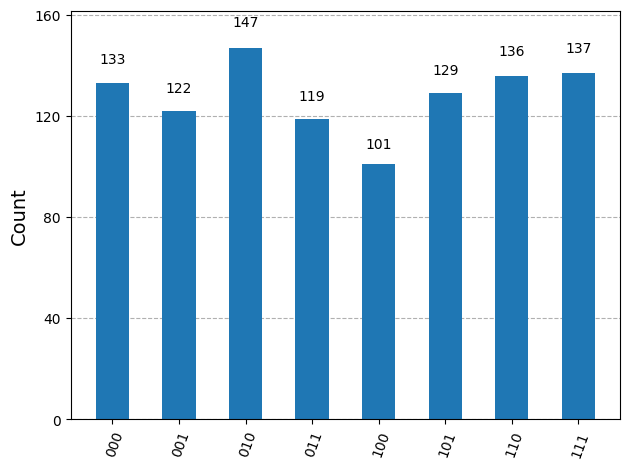


=== UF vs VF Comparison: FA_ESOP ===
| Ref   |   #CEXs |   GI |   P(SAT)% |   Qubits |   Depth |   Gates |
|-------|---------|------|-----------|----------|---------|---------|
| UF    |       0 |    0 |         0 |        7 |       3 |      10 |
| VF    |       0 |    0 |         0 |        6 |       3 |       9 |

=== Done with ESOP version. ===


In [3]:
"""
qSAT-like demo (prototype) using Qiskit + ESOP forms
"""

import math
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from tabulate import tabulate

# ---------------------
# Helper: classical checkers
# ---------------------
def classical_and(x): return x[0] & x[1]
def classical_nand(x): return 1 - (x[0] & x[1])

def classical_mux_GR(x):
    x1, x2, x3 = x
    return ((1 - x1) & x2) | (x1 & x3)

def classical_mux_GbR(x):
    x1, x2, x3 = x
    return x2 ^ (x1 & x2) ^ (x1 & x3)

def classical_fulladder_GR(x):
    x1, x2, x3 = x
    s = (x1 ^ x2) ^ x3
    c = ((x1 ^ x2) & x3) | (x1 & x2)
    return s, c

def classical_fulladder_GbR(x):
    x1, x2, x3 = x
    s = x1 ^ x2 ^ x3
    maj = (x1 & x2) ^ (x1 & x3) ^ (x2 & x3)
    return s, maj

# ---------------------
# ESOP versions (from the paper)
# ---------------------
def esop_mux(x):
    """
    ESOP form of MUX:
    x2 ⊕ (x1 & x2) ⊕ (x1 & x3)
    """
    x1, x2, x3 = x
    return x2 ^ (x1 & x2) ^ (x1 & x3)

def esop_fulladder(x):
    """
    ESOP form of Full Adder:
    SUM = x1 ⊕ x2 ⊕ x3
    CARRY = (x1 & x2) ⊕ (x1 & x3) ⊕ (x2 & x3)
    """
    x1, x2, x3 = x
    s = x1 ^ x2 ^ x3
    c = (x1 & x2) ^ (x1 & x3) ^ (x2 & x3)
    return s, c

# ---------------------
# Counterexample enumeration
# ---------------------
def enumerate_cexs(GF_func, GR_func, n_inputs, multi_output=False):
    cex_list = []
    for i in range(2**n_inputs):
        bits = [(i >> j) & 1 for j in range(n_inputs)]
        if multi_output:
            gf, gr = GF_func(bits), GR_func(bits)
            if any(a ^ b for a, b in zip(gf, gr)):
                cex_list.append(bits)
        else:
            if GF_func(bits) ^ GR_func(bits):
                cex_list.append(bits)
    return cex_list

# ---------------------
# Oracle builder
# ---------------------
def build_phase_oracle_subcircuit_from_matchpatterns(match_patterns, n_inputs, n_aux):
    total_qubits = n_inputs + n_aux + 1
    comp = QuantumCircuit(total_qubits, name="comp_tt")
    in_q = list(range(n_inputs))
    aux_q = list(range(n_inputs, n_inputs + n_aux))
    ans_q = total_qubits - 1

    for patt in match_patterns:
        for idx, bit in enumerate(patt):
            if bit == 0:
                comp.x(in_q[idx])
        comp.mcx(in_q, ans_q, aux_q)
        for idx, bit in enumerate(patt):
            if bit == 0:
                comp.x(in_q[idx])

    oracle = QuantumCircuit(total_qubits, name="oracle_tt")
    oracle.append(comp.to_gate(), list(range(total_qubits)))
    oracle.z(total_qubits - 1)
    oracle.append(comp.to_gate().inverse(), list(range(total_qubits)))
    return oracle, comp

def diffuser_circuit(n):
    qc = QuantumCircuit(n, name="diffuser")
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    return qc

# ---------------------
# Runner
# ---------------------
def run_qsat_example(benchmark_name, n_inputs, n_aux_for_UF, n_aux_for_VF,
                     GF_classical, UF_classical, VF_classical):

    print("\n=== Running qSAT prototype for:", benchmark_name, "===\n")
    cexs_UF = enumerate_cexs(GF_classical, UF_classical, n_inputs,
                             multi_output=(benchmark_name.startswith("FA")))
    cexs_VF = enumerate_cexs(GF_classical, VF_classical, n_inputs,
                             multi_output=(benchmark_name.startswith("FA")))

    results = {}
    scenarios = [("UF", n_aux_for_UF, cexs_UF), ("VF", n_aux_for_VF, cexs_VF)]

    for ref_label, aux_count, match_patterns in scenarios:
        M = len(match_patterns)
        n = n_inputs + aux_count
        GI = int(round((math.pi/4) * math.sqrt((2**n) / M))) if M>0 else 0
        GI = max(GI, 1) if M>0 else 0

        oracle, comp = build_phase_oracle_subcircuit_from_matchpatterns(match_patterns,
                                                                       n_inputs, aux_count)
        total_qubits = n_inputs + aux_count + 1
        search_n = n_inputs + aux_count

        grover_qc = QuantumCircuit(total_qubits, n_inputs)
        grover_qc.h(range(search_n))

        diffuser = diffuser_circuit(search_n)
        for _ in range(GI):
            grover_qc.append(oracle.to_gate(), range(total_qubits))
            grover_qc.append(diffuser.to_gate(), range(search_n))

        grover_qc.append(comp.to_gate(), range(total_qubits))
        grover_qc.measure(range(n_inputs), range(n_inputs))

        sim = Aer.get_backend("aer_simulator")
        tqc = transpile(grover_qc, sim)
        result = sim.run(tqc, shots=1024).result()
        counts = result.get_counts()

        sat_prob = 0.0
        for meas_str, cnt in counts.items():
            bits = [int(ch) for ch in meas_str[::-1]]
            if bits[:n_inputs] in match_patterns:
                sat_prob += cnt/1024

        q_count, depth, gates = grover_qc.num_qubits, grover_qc.depth(), grover_qc.size()
        ops = grover_qc.count_ops()

        # detailed print
        print(f"\n-- {ref_label} results --")
        print("Result counts:", counts)
        print("Circuit depth:", depth)
        print("Total gates:", gates)
        print("Operations count:", ops)

        try:
            grover_qc.draw("mpl")
            plt.show()
            plot_histogram(counts)
            plt.show()
        except: pass

        results[ref_label] = {
            "counts": counts, "P(SAT)": sat_prob,
            "qubits": q_count, "depth": depth,
            "gates": gates, "ops": ops,
            "GI": GI, "match_patterns": match_patterns
        }

    return results

# ---------------------
# Print comparison table
# ---------------------
def print_comparison_table(results, benchmark_name):
    headers = ["Ref", "#CEXs", "GI", "P(SAT)%", "Qubits", "Depth", "Gates"]
    table = []
    for ref_label, data in results.items():
        table.append([
            ref_label, len(data["match_patterns"]),
            data["GI"], f"{data['P(SAT)']*100:.2f}",
            data["qubits"], data["depth"], data["gates"]
        ])
    print(f"\n=== UF vs VF Comparison: {benchmark_name} ===")
    print(tabulate(table, headers=headers, tablefmt="github"))

# ---------------------
# Run examples
# ---------------------
if __name__ == "__main__":
    # AND example
    results_and = run_qsat_example("AND", 2, 1, 1,
                                   GF_classical=classical_nand,
                                   UF_classical=classical_and,
                                   VF_classical=classical_nand)
    print_comparison_table(results_and, "AND")

    # MUX example (GR vs ESOP)
    results_mux = run_qsat_example("MUX_ESOP", 3, 2, 1,
                                   GF_classical=lambda x: classical_mux_GR(x)^1,
                                   UF_classical=classical_mux_GR,
                                   VF_classical=esop_mux)
    print_comparison_table(results_mux, "MUX_ESOP")

    # Full Adder example (GR vs ESOP)
    results_fa = run_qsat_example("FA_ESOP", 3, 3, 2,
                                  GF_classical=lambda x: classical_fulladder_GR(x),
                                  UF_classical=classical_fulladder_GR,
                                  VF_classical=esop_fulladder)
    print_comparison_table(results_fa, "FA_ESOP")

    print("\n=== Done with ESOP version. ===")